# PCC142 - Mineração de Dados
## Agrupamento
### Aluno: Gabriel F. Costa

Considerando o conjunto de dados do desafio Spaceship Titanic e as ferramentas do SKLearn (sklearn.cluster e metrics), faça:

A) crie clusters com os dados de treinamento do desafio sem usar o atributo Transported e usando duas técnicas diferentes;

B) Avalie os resultados usando as métricas homogenety, completeness e V-measure usando o atributo Transported, e silhouette coefficient (avaliação intríseca).

# Bibliotecas

In [7]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score
from sklearn.decomposition import PCA

# Obtendo os dados

In [1]:
!git clone https://github.com/gabrielxcosta/PCC142---Data-Mining.git

Cloning into 'PCC142---Data-Mining'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 48 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 12.10 MiB | 9.83 MiB/s, done.
Resolving deltas: 100% (8/8), done.


# Classe p/ resolução do problema

In [16]:
class TitanicClusteringEvaluator:
    """
    Class to perform clustering on the Spaceship Titanic dataset, evaluate the results, and generate visualizations.

    This class handles:
    - Loading the training dataset from a zip archive.
    - Preprocessing numeric and categorical features (imputation, scaling, encoding).
    - Applying clustering techniques (e.g., KMeans, Agglomerative).
    - Evaluating clusters using:
        * Homogeneity, Completeness, V-measure (external evaluation using 'Transported' as ground truth).
        * Silhouette Coefficient (intrinsic evaluation).
    - Visualizing clusters with PCA projection.
    - Comparing evaluation metrics across different clustering methods.

    """

    def __init__(self, zip_path):
        self.zip_path = zip_path
        self.df_train = None
        self.X = None
        self.y_true = None
        self.num_cols = []
        self.cat_cols = []
        self.preprocessor = None
        self.results = {}

    def load_data(self):
        """Loads the dataset from the zip archive and prepares features and labels."""
        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            with zip_ref.open('train.csv') as train_file:
                self.df_train = pd.read_csv(train_file)

        df = self.df_train.copy()
        self.y_true = df['Transported'].astype(int)
        self.X = df.drop(columns=['Transported', 'PassengerId', 'Name', 'Cabin'])

    def prepare_pipeline(self):
        """Creates preprocessing pipelines for numeric and categorical features."""
        self.num_cols = self.X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.cat_cols = self.X.select_dtypes(include=['object', 'bool']).columns.tolist()

        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        self.preprocessor = ColumnTransformer([
            ('num', num_pipeline, self.num_cols),
            ('cat', cat_pipeline, self.cat_cols)
        ])

    def fit_and_evaluate(self, method_name, clusterer):
        """
        Applies a clustering method, evaluates results, and stores metrics.

        Args:
            method_name (str): Name of the clustering method.
            clusterer: scikit-learn clustering instance.
        """
        X_processed = self.preprocessor.fit_transform(self.X)

        y_pred = clusterer.fit_predict(X_processed)

        homogeneity = homogeneity_score(self.y_true, y_pred)
        completeness = completeness_score(self.y_true, y_pred)
        v_measure = v_measure_score(self.y_true, y_pred)
        silhouette = silhouette_score(X_processed, y_pred)

        self.results[method_name] = {
            'homogeneity': homogeneity,
            'completeness': completeness,
            'v_measure': v_measure,
            'silhouette': silhouette,
            'labels': y_pred
        }

        print(f"\n{'='*40}")
        print(f"Results for {method_name}:")
        print(f"Homogeneity Score : {homogeneity:.4f}")
        print(f"Completeness Score: {completeness:.4f}")
        print(f"V-Measure Score   : {v_measure:.4f}")
        print(f"Silhouette Coef.  : {silhouette:.4f}")
        print(f"{'='*40}")

    def visualize_results(self):
        """Generates subplots with PCA projections and barplot of metrics."""
        sns.set_style('darkgrid')
        num_methods = len(self.results)
        fig, axes = plt.subplots(1, num_methods + 1, figsize=(5 * (num_methods + 1), 5))

        X_processed = self.preprocessor.transform(self.X)
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_processed)

        for i, (method_name, result) in enumerate(self.results.items()):
            labels = result['labels']
            sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set2', s=50, ax=axes[i])
            axes[i].set_title(f'{method_name} (PCA Projection)')
            axes[i].set_xlabel('PCA 1')
            axes[i].set_ylabel('PCA 2')
            axes[i].legend(title='Cluster', facecolor='white')

        df_metrics = pd.DataFrame(self.results).T[['homogeneity', 'completeness', 'v_measure', 'silhouette']]
        df_metrics.plot(kind='bar', ax=axes[-1], colormap='Set2')
        axes[-1].set_title('Comparação de Métricas')
        axes[-1].set_ylabel('Score')
        axes[-1].set_ylim(0, 1)
        axes[-1].grid(axis='y')
        axes[-1].legend(facecolor='white')
        plt.tight_layout()
        plt.show()

# Resultados


Results for KMeans:
Homogeneity Score : 0.0112
Completeness Score: 0.0255
V-Measure Score   : 0.0155
Silhouette Coef.  : 0.4825

Results for Agglomerative:
Homogeneity Score : 0.0221
Completeness Score: 0.0695
V-Measure Score   : 0.0335
Silhouette Coef.  : 0.5296


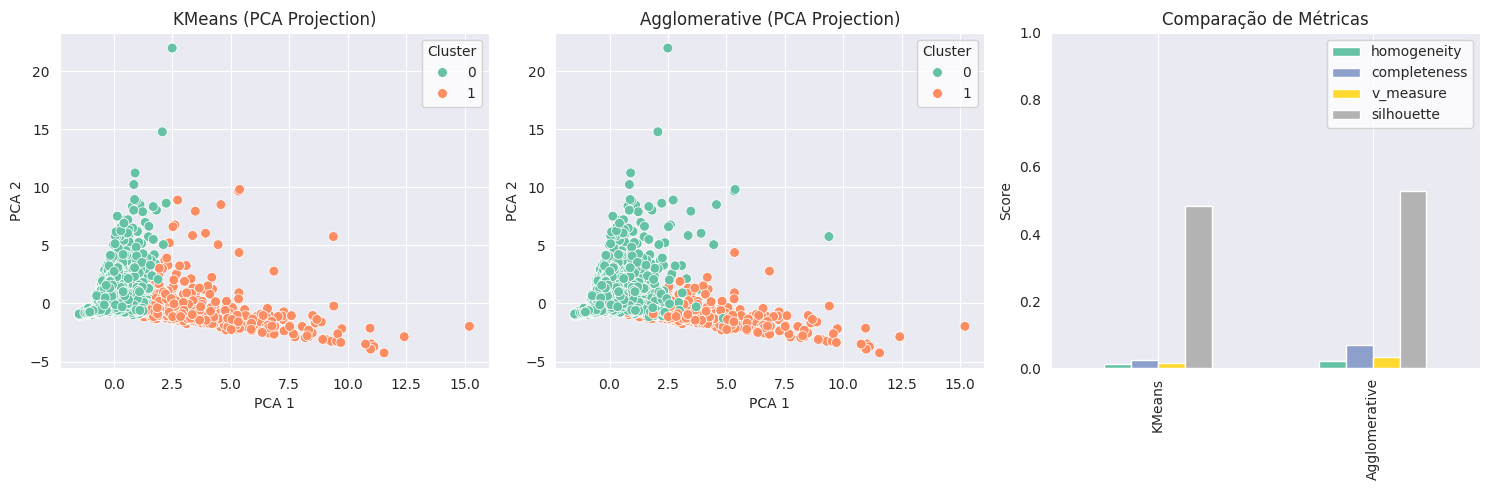


Total execution time: 9.82 seconds


In [17]:
if __name__ == '__main__':
    start_time = time.time()

    path = 'PCC142---Data-Mining/spaceship_titanic/data.zip'
    evaluator = TitanicClusteringEvaluator(zip_path=path)

    evaluator.load_data()
    evaluator.prepare_pipeline()

    evaluator.fit_and_evaluate("KMeans", KMeans(n_clusters=2, random_state=42, n_init=10))
    evaluator.fit_and_evaluate("Agglomerative", AgglomerativeClustering(n_clusters=2))

    evaluator.visualize_results()

    total_time = time.time() - start_time
    print(f"\nTotal execution time: {total_time:.2f} seconds")

### Contexto do Experimento

Neste experimento, aplicamos dois algoritmos de clustering não supervisionado — **KMeans** e **Agglomerative Clustering** — ao conjunto de dados de treinamento do desafio *Spaceship Titanic*.

A variável alvo `Transported` (que indica se o passageiro foi transportado) foi usada **apenas para avaliação externa**, não para treino dos clusters.

### Métricas Avaliadas

* **Homogeneity**: mede se cada cluster contém apenas membros de uma classe verdadeira.
* **Completeness**: mede se todos os membros de uma classe verdadeira estão no mesmo cluster.
* **V-measure**: média harmônica entre homogeneidade e completude.
* **Silhouette Coefficient**: métrica intrínseca que mede a separação dos clusters com base na distância entre pontos dentro do cluster e fora dele.

Valores variam de 0 (pior) a 1 (melhor).

---

### Resultados Obtidos

| Método                  | Homogeneity | Completeness | V-measure | Silhouette |
| ----------------------- | ----------- | ------------ | --------- | ---------- |
| **KMeans (k=2)**        | 0.0112      | 0.0255       | 0.0155    | 0.4825     |
| **Agglomerative (k=2)** | 0.0221      | 0.0695       | 0.0335    | 0.5296     |

---

### Interpretação

* **Homogeneity, Completeness e V-measure estão muito baixos** para ambos os métodos (próximos de zero), indicando que os clusters formados **não correspondem bem à classificação verdadeira `Transported`**. Ou seja, os grupos encontrados não capturam a separação entre passageiros transportados e não transportados.

* O **Silhouette Coefficient apresenta valores moderados (\~0.48 a 0.53)**, o que indica que os clusters são razoavelmente bem definidos em termos de distância entre pontos (internamente coesos e externos separados), independentemente da variável alvo.

* O método Agglomerative teve métricas externas ligeiramente melhores que KMeans, sugerindo uma divisão um pouco mais alinhada ao rótulo `Transported`, mas ainda muito fraca.

---

### Conclusão

* Os clusters formados pelas técnicas usadas **não correspondem diretamente à variável alvo `Transported`**, sugerindo que essa característica pode não estar diretamente refletida nas variáveis utilizadas para clusterização, ou que o problema exige técnicas mais avançadas (e.g., feature engineering, modelos supervisionados).

* No entanto, as boas pontuações no Silhouette indicam que a estrutura dos clusters faz sentido internamente, podendo ser útil para segmentação exploratória, ainda que não reflita diretamente o transporte.

* O objetivo do exercício — criar clusters sem usar `Transported` e avaliar o alinhamento com essa variável — foi cumprido, evidenciando a diferença entre agrupamento não supervisionado e classificação.

